In [1]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.integrate import quad
import pylab as plt
from astropy.io import fits
from astropy.table import Table
import foreground_model as fg

# Foreground model test

## SMF test part

In [2]:
# del SMF_Driver_ETGs
# del SMF_Driver_LTGs
from foreground_model import SMF_Driver_ETGs, SMF_Driver_LTGs
smf = SMF_Driver_ETGs()
# def phi_M(M):
#     M_star = 10**smf.logM_star
#     phi = 10**smf.logphi
#     # phi = 10**-2.5
#     alpha = 1+smf.alpha
#     # alpha = 0.524
#     return np.exp(-M/M_star)*phi*(M/M_star)**alpha

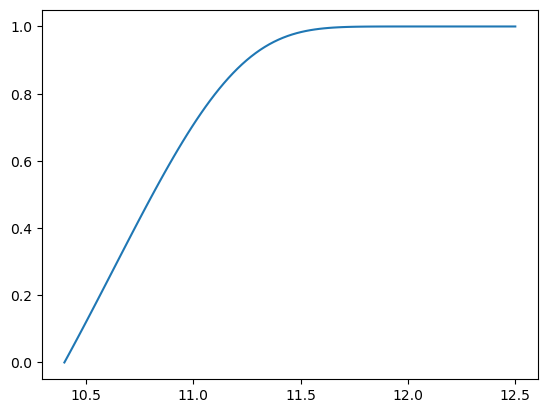

In [3]:
x = np.linspace(10.4,12.5,100)
y = smf.CDF(x)
# plt.yscale('log')
plt.plot(x,y)

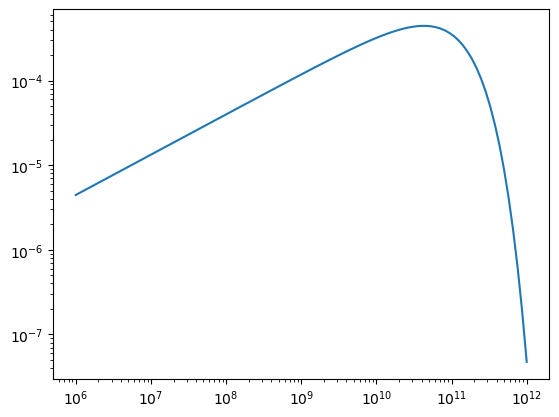

In [36]:
M_ar = np.logspace(6,12,100)
phi_ar = phi_M(M_ar)
plt.plot(M_ar,phi_ar)
plt.yscale('log')
plt.xscale('log')

## redshift distribution test part

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo.differential_comoving_volume(1)

<Quantity 2.65507557e+10 Mpc3 / sr>

In [3]:
z_ar = np.linspace(0,1.5,10000)
com_dist = cosmo.comoving_distance(z_ar).value
dcomdz = np.gradient(com_dist, z_ar)
# plt.plot(z_ar, dcomdz)
cosmo.comoving_distance(1).value**2*splev(1, splrep(z_ar, dcomdz))/cosmo.differential_comoving_volume(1).value

1.0000000016176376

In [2]:
from foreground_model import Redshift_Distribution
rd = Redshift_Distribution()

0.847777378801586


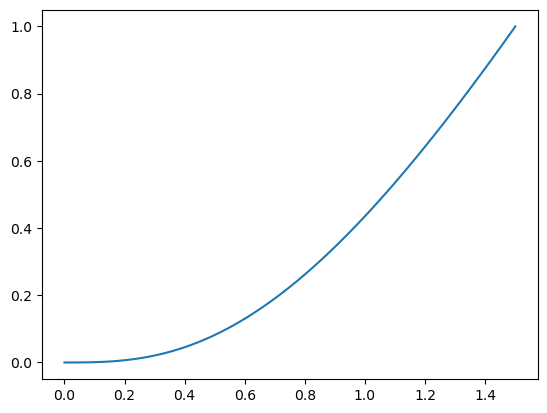

In [4]:
z = np.linspace(0,1.5,100)
plt.plot(z, rd.CDF(z))
print(rd.CDF_inv(0.3))

## Test 10kpccolloar smaple

In [7]:
from astropy.table import Table
sample_etg = Table.read('../data/sample_ETGs_10kpcocllar.fits')
sample_etg = sample_etg[sample_etg['Z']<0.15]
sample_etg = sample_etg[sample_etg['logm_cnn']>10]
sample_ltg = Table.read('../data/sample_LTGs_10kpcocllar.fits')
sample_ltg = sample_ltg[sample_ltg['Z']<0.15]
sample_ltg = sample_ltg[sample_ltg['logm_cnn']>10]

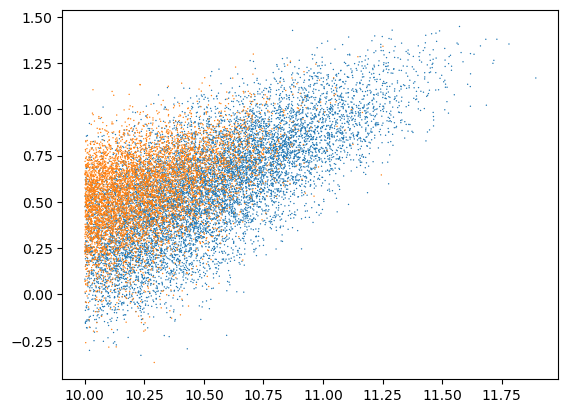

In [8]:
plt.scatter(sample_etg['logm_cnn'],np.log10(sample_etg['re_kpc']), s = 1, edgecolors='none')
plt.scatter(sample_ltg['logm_cnn'],np.log10(sample_ltg['re_kpc']), s = 1, edgecolors='none')
# plt.yscale('log')
# import seaborn as sns
# sns.kdeplot(x = np.array(sample_etg['logm_cnn']).astype('float64'),y = np.array(np.log10(sample_etg['re_kpc'])).astype('float64'), cmap='Blues', fill=0,level = 3)
# sns.kdeplot(x = np.array(sample_ltg['logm_cnn']).astype('float64'),y = np.array(np.log10(sample_ltg['re_kpc'])).astype('float64'), cmap='Reds', fill=0, levels = 3)

### convert $M_{*,10},\Gamma_{*,10}$ to $M_*, R_e$

In [39]:
from scipy.special import gamma, gammainc
from scipy.optimize import fsolve
def b(nser):
    return 2*nser - 1./3. + 4/405./nser + 46/25515/nser**2

def f_to_solve(Re,gammastar10):
    return 2 - gammastar10 - (10**2*np.exp(-b(4)*(10/Re)**(1/4)))/(4*Re**2*b(4)**(-2*4)*gammainc(2*4, b(4)*(10/Re)**(1/4))*gamma(2*4))
fsolve(f_to_solve, 2, args=(1.3))

array([17.49746833])

In [41]:
re_deV_array = np.zeros(len(sample_etg))
for i in range(len(sample_etg)):
    galaxy = sample_etg[i]
    re = galaxy['re_kpc']
    gammastar10 = galaxy['gammastar10']
    re_deV = fsolve(f_to_solve, 2, args=(gammastar10))
    re_deV_array[i] = re_deV

sample_etg.add_column(re_deV_array, name='re_deV')

/tmp/ipykernel_60953/848725475.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  re_deV_array[i] = re_deV


In [ ]:
sample_etg = sample_etg[np.abs(sample_etg['re_deV'] - sample_etg['re_kpc']) < 20]
logm_deV = sample_etg['logm_cnn'] - np.log10(gammainc(2*4, b(4)*(10/sample_etg['re_deV'])**(1/4)))
sample_etg.add_column(logm_deV, name='logm_deV')
sample_etg.write('../data/sample_ETGs_10kpcocllar_deV.fits', overwrite=True)

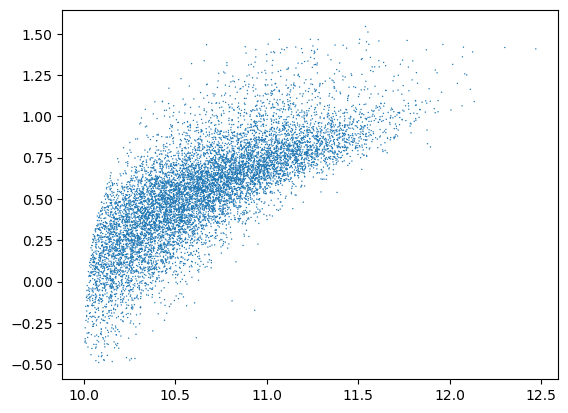

In [59]:
sample_etg = Table.read('../data/sample_ETGs_10kpcocllar_deV.fits')
sample_etg = sample_etg[np.log10(sample_etg['re_deV']) > -0.5]
plt.scatter(sample_etg['logm_deV'],np.log10(sample_etg['re_deV']), s = 1, edgecolors='none')

### fit a linear relation between $M_*, R_e$

In [73]:
from scipy.optimize import minimize,curve_fit
from scipy.stats import norm


In [74]:
popt,pcov = curve_fit(re_M, sample_etg['logm_deV'], np.log10(sample_etg['re_deV']), p0 = [1,1])

In [75]:
popt

array([0.98903784, 0.6068229 ])

In [80]:
norm.pdf(1, loc = 1, scale = -1)

nan

In [92]:
def re_M(logM,a,b):
    return a + b*(logM - 11.4)

def logP(logM,logre,a,b,c):
    P = norm.pdf(logre, loc = re_M(logM,a,b), scale = c)
    # print(P)
    return np.log(P)

def logP_sum(p):
    a,b,c = p
    # print(p)
    logP_sum = 0
    for i in range(len(sample_etg)):
        logM = sample_etg['logm_deV'][i]
        logre = np.log10(sample_etg['re_deV'][i])
        logP_sum += logP(logM,logre,a,b,c)
    # print(logP_sum)
    return -logP_sum

res = minimize(logP_sum, x0 = [1,0.6,0.1], bounds = [[0.5,1.5],[0,np.inf],[0.1,np.inf]])

In [93]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -1832.162218358847
        x: [ 9.890e-01  6.068e-01  2.005e-01]
      nit: 12
      jac: [-1.364e-04 -2.403e-02 -9.027e-03]
     nfev: 76
     njev: 19
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

Text(0.5, 1.0, '$\\mathcal{N}\\left[\\mu_{R,0} + \\beta_R\\left(\\log M_*^{obs} - 11.4 \\right),\\sigma_R^2 \\right]$')

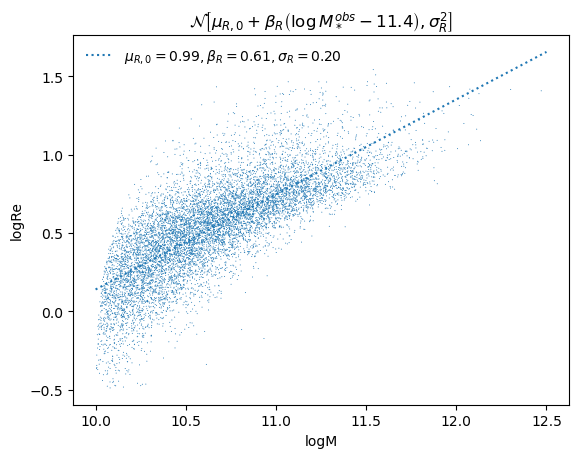

In [105]:
plt.scatter(sample_etg['logm_deV'],np.log10(sample_etg['re_deV']), s = 0.5, edgecolors='none')
plt.plot(np.linspace(10,12.5,100),re_M(np.linspace(10,12.5,100),*res.x[:2]),ls = ':', label = r'$\mu_{R,0}  = %.2f, \beta_R = %.2f, \sigma_R = %.2f$' % tuple(res.x))
plt.legend(frameon = False)
plt.xlabel('logM')
plt.ylabel('logRe')
plt.title(r'$\mathcal{N}\left[\mu_{R,0} + \beta_R\left(\log M_*^{obs} - 11.4 \right),\sigma_R^2 \right]$')


## Ellipticity

In [2]:
from foreground_model import q_distribution

In [3]:
q_dist = q_distribution()
q_ar = np.linspace(0,1,1000)
P_q = q_dist.PDF(q_ar)
cdf_q = q_dist.CDF(q_ar)

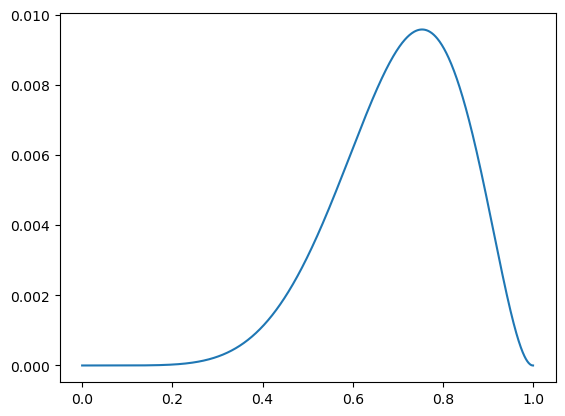

In [4]:
plt.plot(q_ar,P_q)

0.7183661613937842


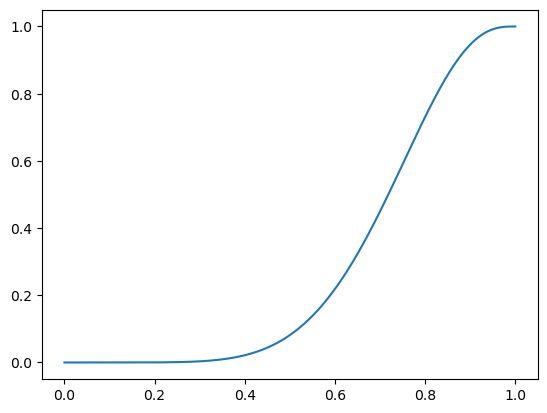

In [6]:
plt.plot(q_ar,cdf_q)
print(q_dist.CDF_inv(0.5))

## Dinos inner density profile of DM

Text(0, 0.5, '$\\gamma_{DM}$')

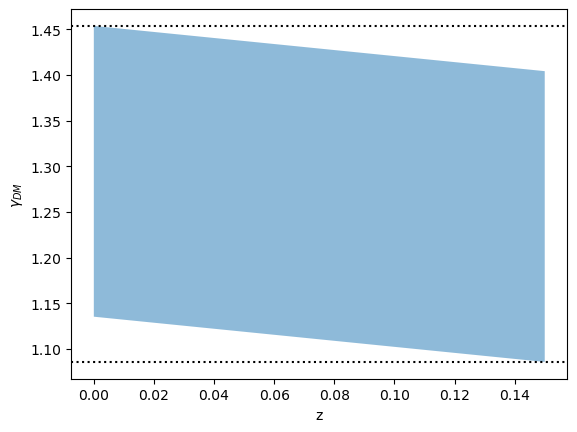

In [39]:
from scipy.stats import norm
def gamma(z):
    mu_gamma = 1.18
    alpha_gamma = -0.33
    return mu_gamma + alpha_gamma*(z - 0.347)

z_array = np.linspace(0,0.15,1000)
upper_array = norm.ppf(0.84, loc = gamma(z_array), scale = 0.16)
lower_array = norm.ppf(0.16, loc = gamma(z_array), scale = 0.16)
plt.fill_between(z_array, lower_array, upper_array, alpha = 0.5)
plt.axhline(np.max(upper_array), color = 'k', linestyle = ':')
plt.axhline(np.min(lower_array), color = 'k', linestyle = ':')
plt.xlabel('z')
plt.ylabel(r'$\gamma_{DM}$')

## Test Colossus

In [7]:
from colossus.halo import concentration
from colossus.cosmology import cosmology
from colossus.lss import mass_function

In [2]:
from foreground_model import concentration_mass_relation
cmr = concentration_mass_relation()
cmr.mu_logc(13)

0.8532818501641055

In [4]:
cosmology.setCosmology('planck13')
mvir_array = 10**(np.linspace(12,15,1000))
z = 0.1
c_dutton = concentration.concentration(mvir_array, 'vir', z, model = 'dutton14')
c_klypin = concentration.concentration(mvir_array, 'vir', z, model = 'klypin16_m')
c_ishiyama = concentration.concentration(mvir_array, 'vir', z, model = 'ishiyama21')
c_duffy = concentration.concentration(mvir_array, 'vir', z, model = 'duffy08')

Text(0, 0.5, '$c_{vir}$')

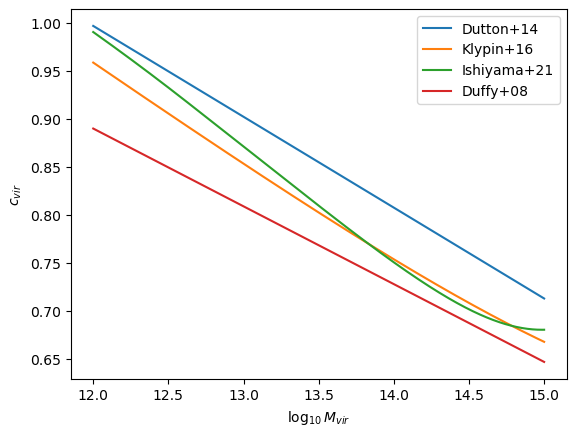

In [5]:
plt.plot(np.log10(mvir_array), np.log10(c_dutton), label = 'Dutton+14')
plt.plot(np.log10(mvir_array), np.log10(c_klypin), label = 'Klypin+16')
plt.plot(np.log10(mvir_array), np.log10(c_ishiyama), label = 'Ishiyama+21')
plt.plot(np.log10(mvir_array), np.log10(c_duffy), label = 'Duffy+08')
plt.legend()
plt.xlabel(r'$\log_{10}M_{vir}$')
plt.ylabel(r'$c_{vir}$')

## Test Mass-Size relation

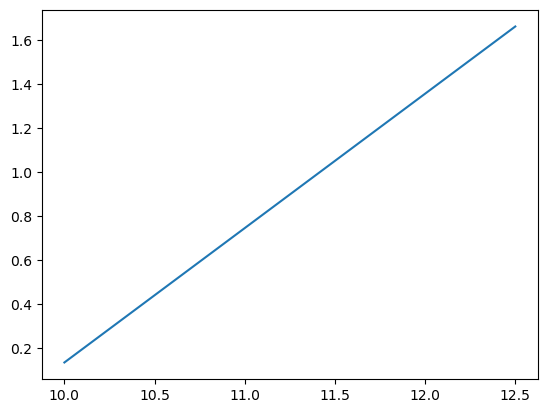

In [3]:
from foreground_model import mass_size_relation
msr = mass_size_relation()
logM = np.linspace(10,12.5,1000)
logRe = msr.mu_logRe(logM)
plt.plot(logM,logRe)

In [6]:
import time
start = time.time()
msr.CDF_inv(11.2,0.5)
print(time.time()-start)

0.0010340213775634766


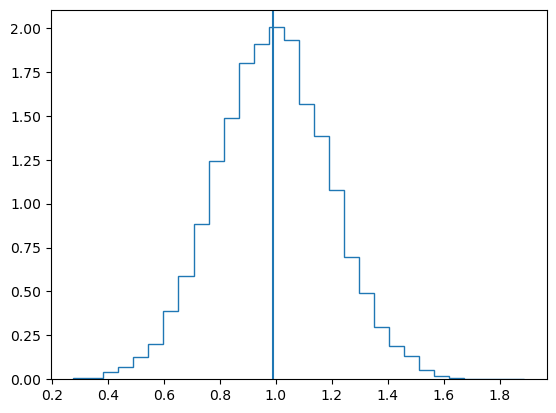

In [9]:
logre_ran = np.zeros(10000)
mu_re = msr.mu_logRe(11.4)
for i in range(10000):
    logre_ran[i] = msr.draw_logRe(11.4)
plt.hist(logre_ran, bins = 30, density = True, histtype='step')
plt.axvline(mu_re)

## Test SHMR

### explore how to convert $P(M_*|M_h)$ to $P(M_h|M_*)$

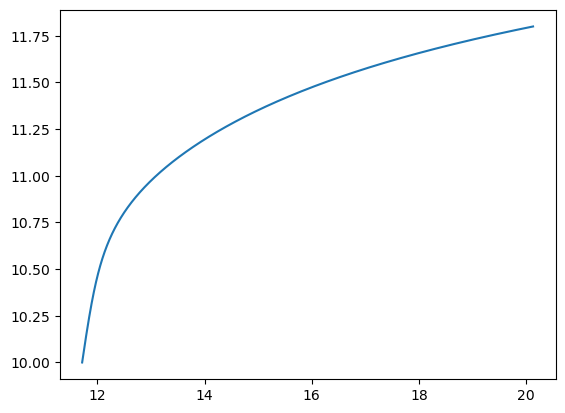

In [3]:
from foreground_model import SHMR
from scipy.interpolate import splrep, splev
zu_shmr = SHMR()
logMstar = np.linspace(10,11.8,1000)
logMh = zu_shmr.mu_logMh(logMstar)
Mstar_mh_interp = splrep(logMh, logMstar)
logMstar_logMh = lambda x: splev(x, Mstar_mh_interp)
plt.plot(logMh,logMstar_logMh(logMh))


In [24]:
print(np.min(logMh), np.max(logMh))

11.71602916782047 20.126806392597008


In [7]:
from scipy.stats import norm 
#* P(logM*|logMh) is a Gaussian
def P_Mstar_Mh(logMstar, logMh):
    sigma = 0.268
    return norm.pdf(logMstar, loc = logMstar_logMh(logMh), scale = sigma)

#* get P(logMh)
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from scipy.integrate import quad
cosmology.setCosmology('planck13')
normalize_factor = quad(lambda x: mass_function.massFunction(10**x, z = 0.1, q_in = 'M', q_out = 'dndlnM', mdef = 'vir', model = 'despali16'), np.min(logMh), np.max(logMh))[0]
intp_Mh = splrep(logMh, mass_function.massFunction(10**logMh, z = 0.1, q_in = 'M', q_out = 'dndlnM', mdef = 'vir', model = 'despali16')/normalize_factor)
P_logMh = lambda x: splev(x, intp_Mh)

#* P(logMh|logM*) = P(logM*|logMh)P(logMh)
def P_Mh_Mstar(logMh, logMstar):
    return P_Mstar_Mh(logMstar, logMh)*P_logMh(logMh)

Text(0, 0.5, '$P(\\log_{10}M_h|\\log_{10}M_*)$')

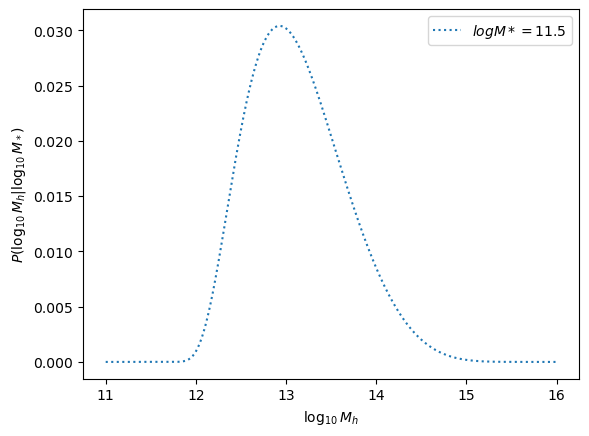

In [11]:
test_logMh = np.linspace(11,16,1000)
# plt.plot(test_logMh, P_Mh_Mstar(test_logMh, 11.1), label = r'$logM* = 11.1$', ls = ':')
# plt.plot(test_logMh, P_Mh_Mstar(test_logMh, 11.3), label = r'$logM* = 11.3$', ls = ':')
plt.plot(test_logMh, P_Mh_Mstar(test_logMh, 11.5), label = r'$logM* = 11.5$', ls = ':')
plt.legend()
plt.xlabel(r'$\log_{10}M_h$')
plt.ylabel(r'$P(\log_{10}M_h|\log_{10}M_*)$')
# print(np.median(P_Mh_Mstar(test_logMh, 11)), np.std(P_Mh_Mstar(test_logMh, 11)))

In [17]:
distribute = P_Mh_Mstar(test_logMh, 11.5)
from scipy.optimize import curve_fit
from scipy.stats import norm
popt, pcov = curve_fit(norm.pdf, test_logMh, distribute, p0 = [13, np.std(test_logMh)])
popt

array([-8.22226921, 13.78758446])

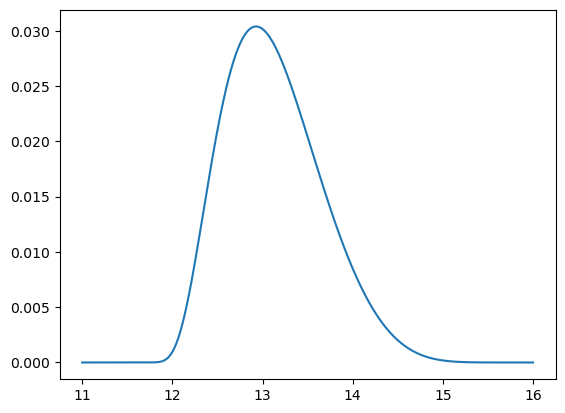

In [18]:
plt.plot(test_logMh, distribute)

Text(0, 0.5, '$\\log_{10}M_h$')

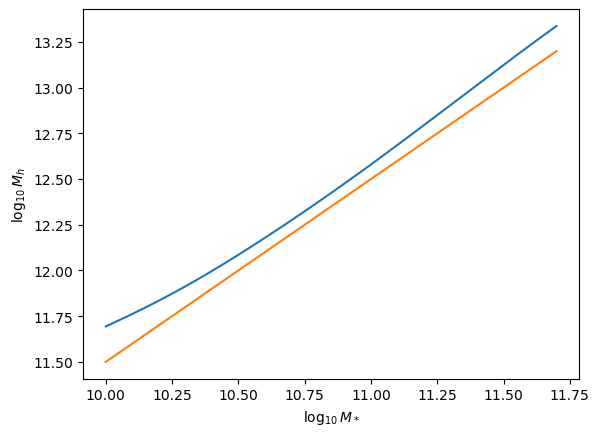

In [22]:
logMstar_list = np.linspace(10,11.7,1000)
mean_Mh_ar = np.zeros(len(logMstar_list))
std_logMh_ar = np.zeros(len(logMstar_list))
for i in range(len(logMstar_list)):
    logMstar = logMstar_list[i]
    distribute = P_Mh_Mstar(test_logMh, logMstar)
    normalized_distribute = distribute / np.sum(distribute)
    mean_logMh = np.sum(test_logMh * normalized_distribute)
    variance_logMh = np.sum((test_logMh - mean_logMh)**2 * normalized_distribute)
    std_logMh = np.sqrt(variance_logMh)
    # median_Mh_ar[i] = test_logMh[np.where(distribute == np.max(distribute))]
    mean_Mh_ar[i] = mean_logMh
    std_logMh_ar[i] = std_logMh
plt.plot(logMstar_list, mean_Mh_ar)
plt.plot(logMstar_list, 13.0+(logMstar_list-11.5))
plt.xlabel(r'$\log_{10}M_*$')
plt.ylabel(r'$\log_{10}M_h$')

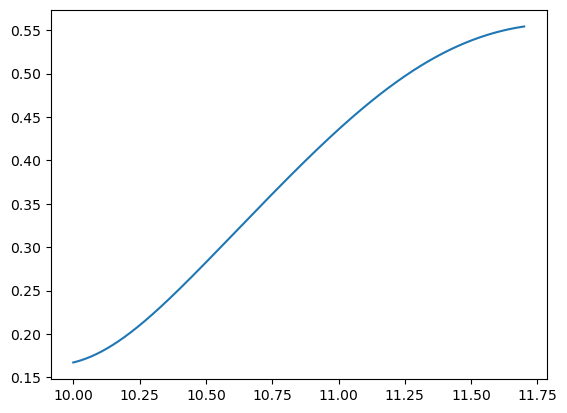

In [23]:
plt.plot(logMstar_list, std_logMh_ar)

### test

Text(0, 0.5, '$\\log_{10}M_h$')

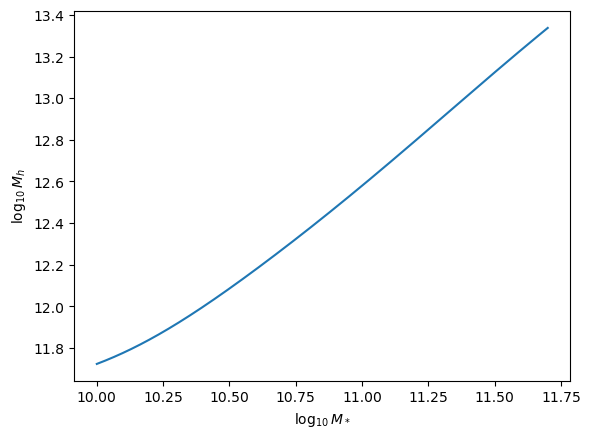

In [4]:
from foreground_model import SHMR
shmr = SHMR()
logMstar_array = np.linspace(10,11.7,1000)
plt.plot(logMstar_array, shmr.mu_Mh_Mstar(logMstar_array))
plt.xlabel(r'$\log_{10}M_*$')
plt.ylabel(r'$\log_{10}M_h$')

Text(0, 0.5, '$\\sigma_{\\log_{10}M_h}$')

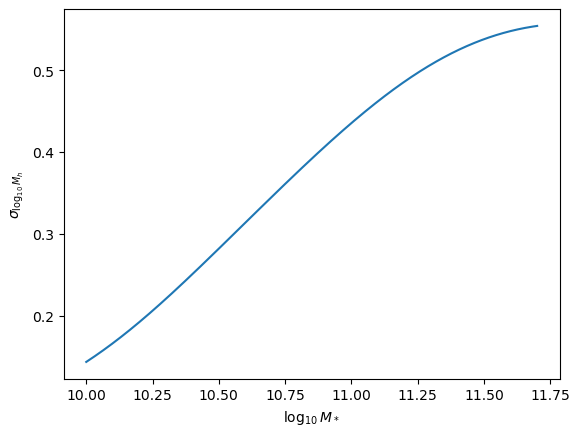

In [5]:
plt.plot(logMstar_array, shmr.sigma_Mh_Mstar(logMstar_array))
plt.xlabel(r'$\log_{10}M_*$')
plt.ylabel(r'$\sigma_{\log_{10}M_h}$')

In [6]:
import time
start = time.time()
shmr.CDF_inv(11.5,0.5)
print(time.time()-start)

0.0011835098266601562


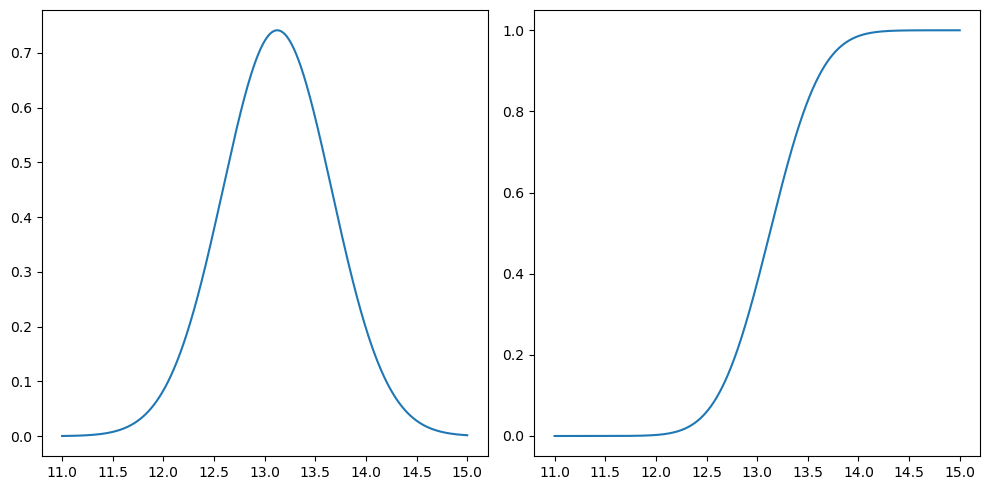

In [7]:
logmh_array = np.linspace(11,15,1000)
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].plot(logmh_array, shmr.PDF(logmh_array,11.5))

ax[1].plot(logmh_array, shmr.CDF(logmh_array,11.5))
plt.tight_layout()

## Magnitude distribution

In [4]:
import h5py
f = h5py.File('/root/software/pygalaxev/examples/vst_mags_grid_z=0.1500_fast.hdf5', 'r')

In [60]:
from scipy.stats import lognorm, rayleigh
arg_lognorm = lognorm.fit(np.array(f['J_mag']).reshape(-1))
arg_rayleigh = rayleigh.fit(np.array(f['J_mag']).reshape(-1))

/root/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


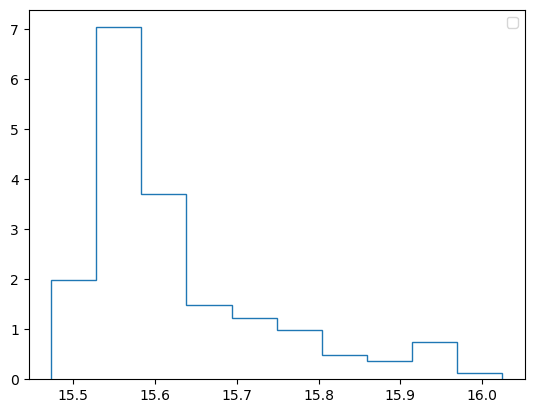

In [5]:
jmag = np.linspace(14.5,15.2,100)
# plt.plot(jmag, rayleigh.pdf(jmag, *arg_rayleigh), label = 'rayleigh')
# plt.plot(jmag, lognorm.pdf(jmag, *arg_lognorm), label = 'lognorm')
plt.hist(np.array(f['J_mag']).reshape(-1), bins = 10, density = True, histtype='step')
plt.legend()

Text(0, 0.5, 'PDF')

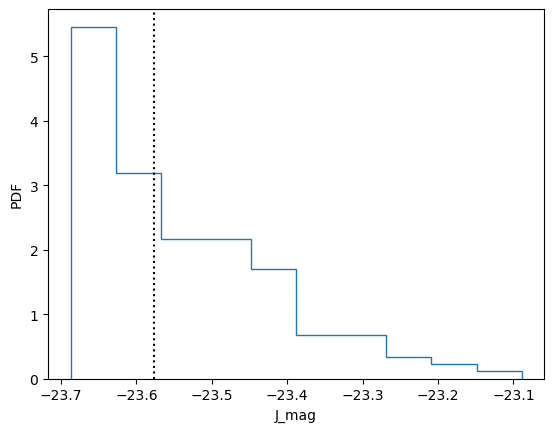

In [4]:
plt.hist(np.array(f['J_mag']).reshape(-1),bins = 10, histtype='step', density = True)
plt.axvline(np.median(np.array(f['J_mag']).reshape(-1)), color = 'k', linestyle = ':')
# plt.show()
plt.xlabel('J_mag')
plt.ylabel('PDF')

In [32]:
print(np.median(np.array(f['J_mag']).reshape(-1)))
print(np.std(np.array(f['J_mag']).reshape(-1)))

14.675014726861143
0.11728922544271844


## Test sigma_gnfw

In [17]:
from numba import jit
from scipy.integrate import quad
@jit(nopython=True)
def test():
    a = np.linspace(0,1,100)
    b = np.linspace(0,1,100)
    return np.trapz(a,b)

In [18]:
test()

0.49999999999999994

In [13]:
import time
start = time.time()
Sigmagnfw(1,1,1)
print(time.time()-start)

0.00011372566223144531


In [14]:
n = 4
2*n - 1./3. + 4/405./n + 46/25515/n**2

7.669248481285519

In [22]:
import os 
os.path.exists('./draw_foreground.py')

True

## Number of galaxies we should simulate

To make a volumn limited sample, we choose to stop at a minimumu stellar mass $\log M_* = 10.4$

(1e-07, 0.001)

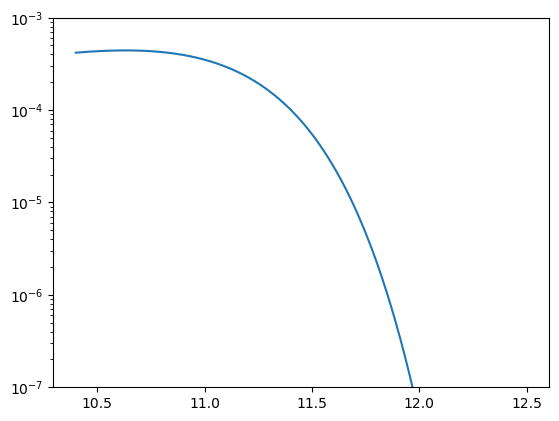

In [20]:
from foreground_model import SMF_Driver_ETGs
import astropy.units as u
smf = SMF_Driver_ETGs()
logMstar_array = np.linspace(10.4,12.5,10000)
n_comoving = smf.PDF(logMstar_array)
plt.plot(logMstar_array, n_comoving)
plt.yscale('log')
plt.ylim(1e-7,1e-3)

In [23]:
N = np.trapz(n_comoving, logMstar_array)
com_volume = fg.cosmo_astropy.comoving_volume(0.15).value
frac_sky = 18000*(u.deg**2).to('rad^2')/(4*np.pi)
num_to_simulate = frac_sky*N*com_volume

In [24]:
num_to_simulate

171143.8955623686

# Background model test

In [2]:
import background_source as bs
oii = bs.OII_emitter()
L = np.linspace(40,43,100)
z = 0.46
phi = oii.Phi_L_z(L,z)

In [3]:
oii.set_CDF_L_inv_interp()

(1e-06, 0.1)

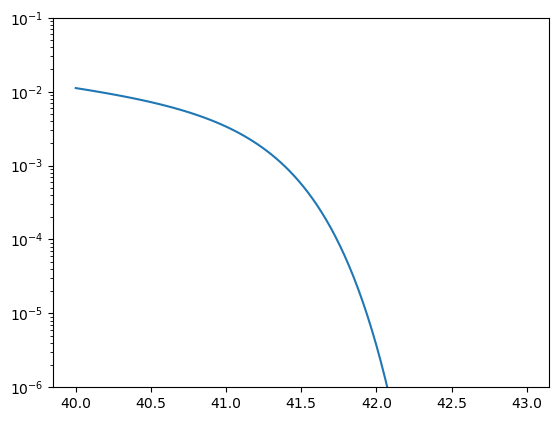

In [4]:
plt.plot(L,phi)
plt.yscale('log')
plt.ylim(1e-6,1e-1)

In [13]:
print(quad(lambda x: oii.Phi_L_z(x,z), 40, 43)[0]/quad(lambda x: oii.Phi_L_z(x,z), 41, 43)[0])
import astropy.units as u
print(bs.fiducial_mean_N/u.sr.to(u.arcmin**2))


8.437605504942862
133.62512288310108


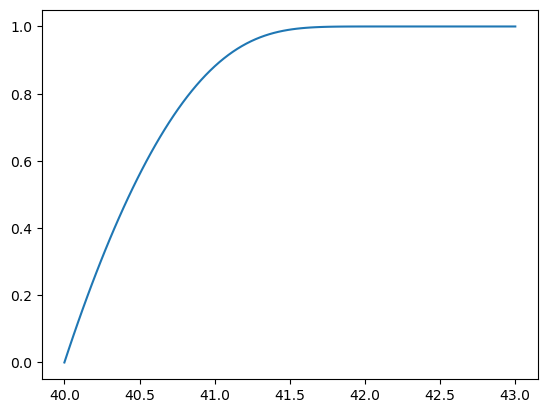

In [ ]:
plt.plot(L, oii.CDF_Phi(L,np.ones(100)*z))
